In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl
from scipy.stats import chi2
import time

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

def fpStat(psr, f0):
    """
    Computes the Fp-statistic as defined in Ellis, Siemens, Creighton (2012)
    :param psr: List of pulsar object instances
    :param f0: Gravitational wave frequency
    :return: Value of the Fp statistic evaluated at f0
    """

    fstat=0.
    npsr = len(psr)

    # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
    N = np.zeros(2)
    # define M matrix M_ij=(A_i|A_j)
    M = np.zeros((2, 2))
    for ii,p in enumerate(psr):

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = 1./f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = 1./f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)

        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(p.invCov, p.residuals)), \
                      np.dot(A[1,:], np.dot(p.invCov, p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(p.invCov, A[kk,:]))
        
        # take inverse of M
        Minv = np.linalg.inv(M)
        fstat += 0.5 * np.dot(N, np.dot(Minv, N))

    # return F-statistic
    return fstat


def feStat(psr, gwtheta, gwphi, f0):
    """ 
    Computes the F-statistic as defined in Ellis, Siemens, Creighton (2012)   
    :param psr: List of pulsar object instances
    :param gwtheta: GW polar angle
    :param gwphi: GW azimuthal angle
    :param f0: Gravitational wave frequency
    :return: Value of the Fe statistic evaluated at gwtheta, phi, f0
    """
    
    npsr = len(psr)
    N = np.zeros(4)
    M = np.zeros((4,4))
    for ii, p in enumerate(psr):
        fplus, fcross, cosMu = createAntennaPatternFuncs(p, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)


        N += np.array([np.dot(A[0,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[1,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[2,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[3,:], np.dot(p.invCov, p.res))]) 

        M += np.dot(A, np.dot(p.invCov, A.T))

    # inverse of M
    Minv = np.linalg.pinv(M)

    # Fe-statistic
    return 0.5 * np.dot(N, np.dot(Minv, N))

In [3]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'red_noise_log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'red_noise_gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [5]:
datadir = enterprise.__path__[0] + '/datafiles/ng9/'

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(datadir + '/*noise.txt'))

In [5]:
#Trial with a few pulsars
parfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.gls.par'
parfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.gls.par'

timfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.tim'
timfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.tim'

noisefile_J0030 = datadir + 'J0030+0451_noise.txt'
noisefile_B1937 = datadir + 'B1937+21_noise.txt'

psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
psr_B1937 = Pulsar(parfile_B1937,timfile_B1937)

psrs_test = [psr_J0030,psr_B1937]

#Get parameter dict from noisefiles
params_test = {}
params_test.update(get_noise_from_pal2(noisefile_J0030))
params_test.update(get_noise_from_pal2(noisefile_B1937))

In [6]:
#All of the Pulsars! Except J0218+4232 because it is naughty and doesn't have a noise file.
psrs_full = []

for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    if psr.name != 'J0218+4232':
        psrs_full.append(psr)

In [8]:
#Get parameter dict from noisefiles
params_full = {}
for nfile in noisefiles:
    params_full.update(get_noise_from_pal2(nfile))
print(params_full)

{'B1855+09_430_PUPPI_efac': 1.12121, 'B1855+09_L-wide_PUPPI_efac': 1.51117, 'B1855+09_430_ASP_efac': 1.13965, 'B1855+09_L-wide_ASP_efac': 1.14383, 'B1855+09_430_ASP_log10_ecorr': -7.38511, 'B1855+09_430_PUPPI_log10_ecorr': -7.28084, 'B1855+09_L-wide_ASP_log10_ecorr': -6.10018, 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.48309, 'B1855+09_430_PUPPI_log10_equad': -7.96027, 'B1855+09_L-wide_PUPPI_log10_equad': -6.42638, 'B1855+09_430_ASP_log10_equad': -8.09925, 'B1855+09_L-wide_ASP_log10_equad': -6.31998, 'B1855+09_red_noise_log10_A': -13.8485, 'B1855+09_red_noise_gamma': 3.88472, 'B1937+21_red_noise_log10_A': -13.1687, 'B1937+21_red_noise_gamma': 2.41503, 'B1937+21_Rcvr_800_GUPPI_efac': 4.799, 'B1937+21_Rcvr_800_GASP_efac': 2.076, 'B1937+21_S-wide_ASP_efac': 1.289, 'B1937+21_Rcvr1_2_GUPPI_efac': 1.618, 'B1937+21_L-wide_ASP_efac': 2.06, 'B1937+21_S-wide_PUPPI_efac': 3.941, 'B1937+21_L-wide_PUPPI_efac': 2.396, 'B1937+21_Rcvr1_2_GASP_efac': 1.217, 'B1937+21_Rcvr_800_GUPPI_log10_equad': -7.35655,

In [8]:
def GetTspan(psrs):
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)
    return Tspan

In [9]:
##### parameters and priors #####
selection = Selection(selections.by_backend)

Tspan_full = GetTspan(psrs_full)
Tspan_test = GetTspan(psrs_test)

# white noise parameters
efac = parameter.Constant()
log10_equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.Constant()
gamma = parameter.Constant()

'''
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')
'''

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn_f = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_full)
rn_t = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_test)

'''
# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''

# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=log10_equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# full model is sum of components
model_full = tm + ef + eq + ec + rn_f
model_test = tm + ef + eq + ec + rn_t

# intialize PTA
pta_test = signal_base.PTA([model_full(psr) for psr in psrs_test])
pta_full = signal_base.PTA([model_test(psr) for psr in psrs_full])

In [10]:
#Set Default PTA parameters to the ones in the noisefiles
pta_test.set_default_params(params_test)
pta_full.set_default_params(params_full)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.13871
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.917359
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.12336
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.14101
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_equad to -8.27762
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_equad to -5.94568
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_equad to -8.17663
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_log10_equad to -6.67303
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_ecorr to -7.6001
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_ecorr to -7.11084
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_ecorr to -7.59912
INFO: enterprise.signals.sig

INFO: enterprise.signals.signal_base: Setting J0023+0923_430_ASP_efac to 1.03662
INFO: enterprise.signals.signal_base: Setting J0023+0923_430_PUPPI_efac to 0.986704
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_ASP_efac to 1.1745
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_PUPPI_efac to 1.30208
INFO: enterprise.signals.signal_base: Setting J0023+0923_430_ASP_log10_equad to -8.36052
INFO: enterprise.signals.signal_base: Setting J0023+0923_430_PUPPI_log10_equad to -8.50979
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_ASP_log10_equad to -7.68848
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_PUPPI_log10_equad to -8.23718
INFO: enterprise.signals.signal_base: Setting J0023+0923_430_ASP_log10_ecorr to -7.2878
INFO: enterprise.signals.signal_base: Setting J0023+0923_430_PUPPI_log10_ecorr to -7.5305
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_ASP_log10_ecorr to -7.03185
INFO: enterprise.signals.signa

INFO: enterprise.signals.signal_base: Setting J1024-0719_Rcvr_800_GUPPI_log10_ecorr to -7.29206
INFO: enterprise.signals.signal_base: Setting J1024-0719_red_noise_log10_A to -16.2659
INFO: enterprise.signals.signal_base: Setting J1024-0719_red_noise_gamma to 3.338
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GASP_efac to 1.12806
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GUPPI_efac to 1.32475
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GASP_efac to 1.49365
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GUPPI_efac to 1.35131
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GASP_log10_equad to -8.04522
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GUPPI_log10_equad to -8.37397
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GASP_log10_equad to -8.08877
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GUPPI_log10_equad to -8.40589
INFO: e

INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GASP_log10_ecorr to -7.21635
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GUPPI_log10_ecorr to -7.23259
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GASP_log10_ecorr to -7.76923
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_log10_ecorr to -6.70639
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_log10_ecorr to -6.95628
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_PUPPI_log10_ecorr to -6.94551
INFO: enterprise.signals.signal_base: Setting J1713+0747_red_noise_log10_A to -19.1114
INFO: enterprise.signals.signal_base: Setting J1713+0747_red_noise_gamma to 1.7124
INFO: enterprise.signals.signal_base: Setting J1738+0333_L-wide_ASP_efac to 1.14947
INFO: enterprise.signals.signal_base: Setting J1738+0333_L-wide_PUPPI_efac to 1.15681
INFO: enterprise.signals.signal_base: Setting J1738+0333_S-wide_ASP_efac to 0.943157
INFO: ent

INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_ecorr to -7.63276
INFO: enterprise.signals.signal_base: Setting J2010-1323_red_noise_log10_A to -16.4803
INFO: enterprise.signals.signal_base: Setting J2010-1323_red_noise_gamma to 3.42768
INFO: enterprise.signals.signal_base: Setting J2017+0603_430_PUPPI_efac to 1.0486
INFO: enterprise.signals.signal_base: Setting J2017+0603_L-wide_PUPPI_efac to 1.15216
INFO: enterprise.signals.signal_base: Setting J2017+0603_S-wide_ASP_efac to 0.861167
INFO: enterprise.signals.signal_base: Setting J2017+0603_S-wide_PUPPI_efac to 1.26673
INFO: enterprise.signals.signal_base: Setting J2017+0603_430_PUPPI_log10_equad to -8.09404
INFO: enterprise.signals.signal_base: Setting J2017+0603_L-wide_PUPPI_log10_equad to -8.59392
INFO: enterprise.signals.signal_base: Setting J2017+0603_S-wide_ASP_log10_equad to -7.65776
INFO: enterprise.signals.signal_base: Setting J2017+0603_S-wide_PUPPI_log10_equad to -8.4567
INFO: enterprise.signals

########## FOR TESTING PURPOSES ONLY #################

fpstat = 0.0
f0 = 7e-8
#Internals of Fstat for test pta
TNrs = pta_test.get_TNr(xs_test)
TNTs = pta_test.get_TNT(xs_test)
phiinvs = pta_test.get_phiinv(xs_test, logdet=False, method='partition')
Nvecs = pta_test.get_ndiag(xs_test)
Ts = pta_test.get_basis(xs_test)
Nmat = []

for ii,p in enumerate(psrs):
    phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
    Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
    cf = sl.cho_factor(Sigma)      
    #Put pulsar's autoerrors in a diagonal matrix
    Ndiag = np.diag(1.0/Nvec)
    Tt = np.transpose(T)
    TtN = np.dot(Tt,Ndiag)
    expval2 = sl.cho_solve(cf,TtN)
    TtNt = np.transpose(TtN)
        
    #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
    Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
    # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
    N = np.zeros(2)
    # define M matrix M_ij=(A_i|A_j)
    M = np.zeros((2, 2))

    # Define A vector
    A = np.zeros((2, len(p.toas)))
    A[0,:] = f0**(-1./3.) * np.sin(2*f0*newtoas[ii])
    A[1,:] = f0**(-1./3.) * np.cos(2*f0*newtoas[ii])
    
    # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
    N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
    # define M matrix M_ij=(A_i|A_j)
    for jj in range(2):
        for kk in range(2):
            M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
    # take inverse of M
    Minv = sl.pinv(M)
        
    fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    

print(fpstat)

In [11]:
# make sure all pulsar have same reference time
def GetRefTime(psrs):
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time
    for p in psrs:
        newtoas.append((p.toas - tref))
    return newtoas

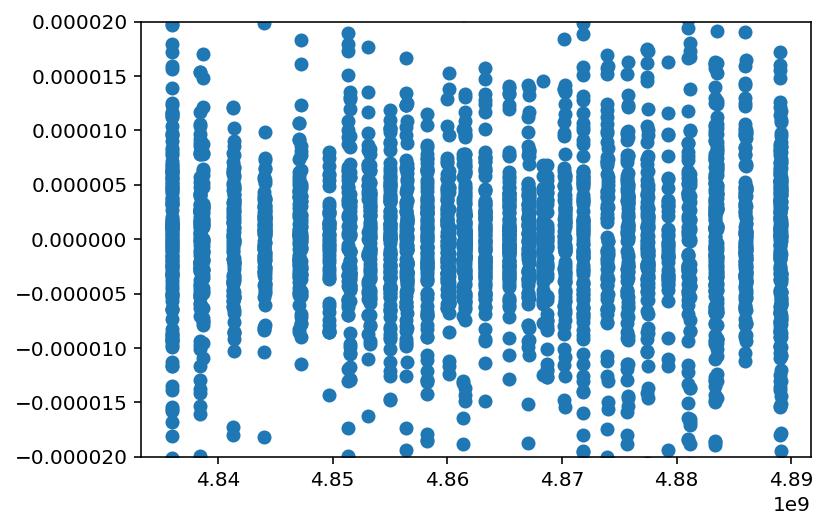

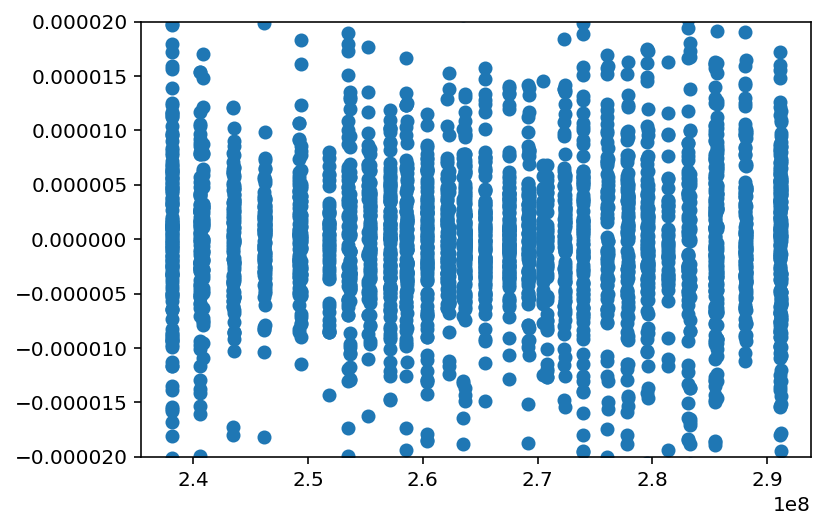

In [14]:
########## FOR TESTING PURPOSES ONLY #################
num = 5
plt.scatter(psrs_full[num].toas,psrs_full[num].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()

plt.scatter(GetRefTime(psrs_full)[num],psrs_full[num].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()



########## TAKES FOREVER TO RUN, USE ANDREWFPSTAT2 AND GETNMATRIX #################
def AndrewFpstat(pta,psrs,params,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    
    Ts = pta.get_basis(params)
    Nmat = []
    
    # make sure all pulsar have same reference time
    #Unsure if necessary
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time and convert to seconds
    for p in psrs:
        newtoas.append((p.toas - tref))
    
    fpstat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        print(ii)
        TtN = Nvec.solve(other = np.eye(np.shape(p.residuals)[0]),left_array = T)
        Ndiag = Nvec.solve(other = np.eye(np.shape(p.residuals)[0]),left_array = np.eye(np.shape(p.residuals)[0]))
    
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*newtoas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*newtoas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return fpstat

In [15]:
def GenNmat(pta,params):
    '''Makes the Nmatrix used in the fstatistic'''
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition') 
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    #Get the basis matrix
    Ts = pta.get_basis(params)
    Nmat = []
    print('Making Nmat')
    l1 = np.shape(TNTs)[0]
    i = 1
    
    for phiinv, TNT, Nvec, T in zip(phiinvs, TNTs, Nvecs, Ts):
        start = time.time()
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        Nshape = np.shape(T)[0]
        TtN = Nvec.solve(other = np.eye(Nshape),left_array = T)
        
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = Nvec.solve(other = np.eye(Nshape),left_array = np.eye(Nshape))
    
        expval2 = sl.cho_solve(cf,TtN)
        #TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtN.T,expval2))
        end = time.time()
        print(repr(i) + ' out of ' + repr(l1) + ' Done. Time: ' + repr(end-start))
        i += 1
    return Nmat

In [16]:
Nmat_test = GenNmat(pta_test,params_test)

Making Nmat
1 out of 2 Done. Time: 5.928197622299194
2 out of 2 Done. Time: 168.81737327575684


In [17]:
#Making and saving Nmatrix so it doesn't need to be calculated again
Nmat_full = GenNmat(pta_full,params_full)

Making Nmat
1 out of 37 Done. Time: 22.65067195892334
2 out of 37 Done. Time: 167.979008436203
3 out of 37 Done. Time: 0.4778869152069092
4 out of 37 Done. Time: 25.643757581710815
5 out of 37 Done. Time: 5.7624733448028564
6 out of 37 Done. Time: 3.5677008628845215
7 out of 37 Done. Time: 75.21762919425964
8 out of 37 Done. Time: 3.8038392066955566
9 out of 37 Done. Time: 0.05184125900268555
10 out of 37 Done. Time: 253.52058935165405
11 out of 37 Done. Time: 16.794402360916138
12 out of 37 Done. Time: 31.264331102371216
13 out of 37 Done. Time: 69.77014327049255
14 out of 37 Done. Time: 55.30612134933472
15 out of 37 Done. Time: 7.677173376083374
16 out of 37 Done. Time: 61.6671142578125
17 out of 37 Done. Time: 596.5425004959106
18 out of 37 Done. Time: 5.46012806892395
19 out of 37 Done. Time: 0.6900591850280762
20 out of 37 Done. Time: 103.29244923591614
21 out of 37 Done. Time: 2.7291464805603027
22 out of 37 Done. Time: 0.11845898628234863
23 out of 37 Done. Time: 0.498231410980

In [42]:
def AndrewFpstat2(psrs,Nmat,aligned_toas,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    
    fpstat = 0.0
        
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(aligned_toas[ii])))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    return fpstat

In [19]:
f0_full = 1/Tspan_full
f0_test = 1/Tspan_test
print(f0_full)
print(f0_test)

3.421256282315104e-09
3.4735783035525875e-09


In [20]:
newtoas_full = GetRefTime(psrs_full)
print(AndrewFpstat2(psrs_full,Nmat_full,newtoas_full,f0_full))

64.04408110488787


In [43]:
newtoas_test = GetRefTime(psrs_test)
print(AndrewFpstat2(psrs_test,Nmat_test,newtoas_test,f0_test))

3.1005476983976346


In [22]:
nfreqs = 1000
Tspan = Tspan_full
freqs = np.logspace(np.log10(1/Tspan),np.log10(3.3e-7),nfreqs)

i = 1
fstat_array_full = []
#fstat_array_test = []
start = time.time()
for gwfreq in freqs:
    fstat_array_full.append(AndrewFpstat2(psrs_full,Nmat_full,newtoas_full,gwfreq))
    #fstat_array_test.append(AndrewFpstat2(psrs_test,Nmat_test,newtoas_test,gwfreq))
    if i % 50 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

50 Done.  Time Elapsed: 139.18851804733276
100 Done.  Time Elapsed: 278.9299638271332
150 Done.  Time Elapsed: 419.9592275619507
200 Done.  Time Elapsed: 562.6481094360352
250 Done.  Time Elapsed: 704.093959569931
300 Done.  Time Elapsed: 846.7511644363403
350 Done.  Time Elapsed: 987.5001771450043
400 Done.  Time Elapsed: 1131.3656067848206
450 Done.  Time Elapsed: 1273.98273229599
500 Done.  Time Elapsed: 1416.165073633194
550 Done.  Time Elapsed: 1557.4013364315033
600 Done.  Time Elapsed: 1699.4157347679138
650 Done.  Time Elapsed: 1843.0145726203918
700 Done.  Time Elapsed: 1987.9424228668213
750 Done.  Time Elapsed: 2130.595443725586
800 Done.  Time Elapsed: 2272.6312646865845
850 Done.  Time Elapsed: 2416.8243622779846
900 Done.  Time Elapsed: 2561.5784542560577
950 Done.  Time Elapsed: 2706.835594177246
1000 Done.  Time Elapsed: 2849.3769948482513


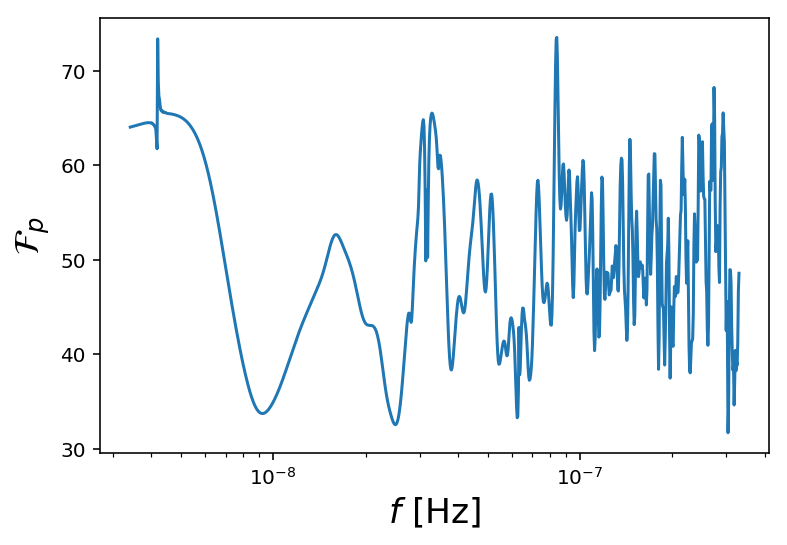

In [35]:
plt.plot(freqs,fstat_array_full)
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.xlabel(r'$f$ [Hz]',fontsize = 'xx-large')
plt.show()

In [57]:
dof_full = 2*len(psrs_full)
x = np.linspace(20,100,nfreqs)

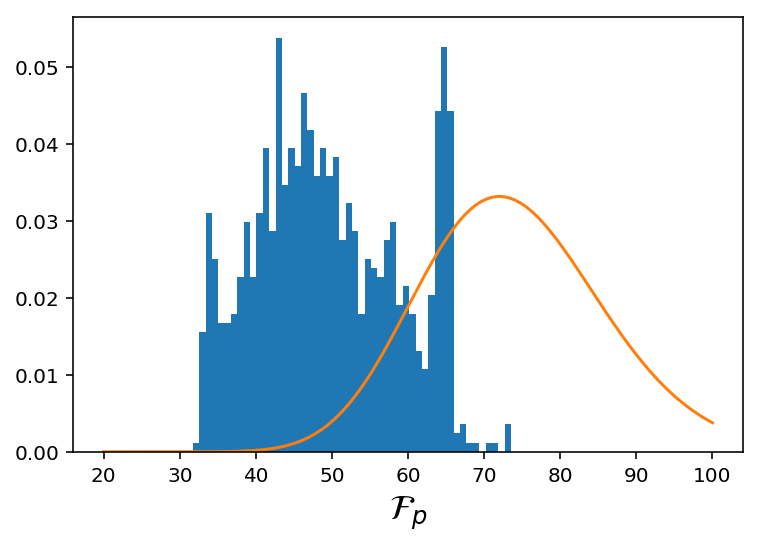

In [58]:
nbins = 50
#plt.hist(fstat_array,bins = nbins,density = True)
plt.hist(fstat_array_full,bins = nbins,density = True)
plt.plot(x,chi2.pdf(x,dof_full))
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.show()

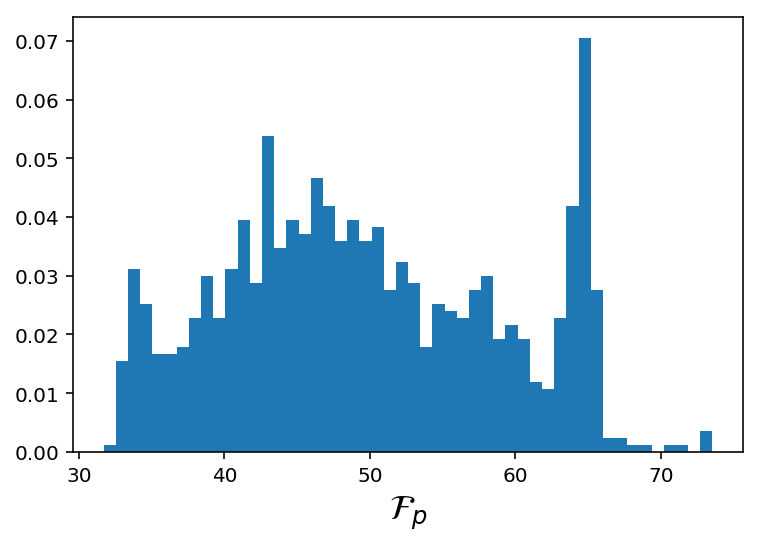

In [545]:
nbins = 50
#plt.hist(fstat_array,bins = nbins,density = True)
plt.hist(fstat_array_full,bins = nbins,density = True)
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.show()

########## TAKES FOREVER TO RUN, USE ANDREWFPSTAT2 AND GETNMATRIX #################
def AndrewFestat(pta,psrs,f0,gwphi,gwtheta):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    the orbital frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    params = pta.params #come up with a more clever way of doing this

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    Ts = pta.get_basis(params)
    Nmat = []
    
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = np.diag(1.0/Nvec)
        Tt = np.transpose(T)
        TtN = np.dot(Tt,Ndiag)
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*f0*p.toas)


        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        M += np.dot(A, np.dot(p.invCov, np.transpose(A)))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [24]:
def AndrewFestat2(psrs,Nmat,aligned_toas,f0,gwphi,gwtheta):
    '''Takes in the pulsars that make up the pta, the Nmatrix from GetNmat 
    (Should make this a function in ptas to use self instead of pta?),
    the frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(aligned_toas[ii])))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])

        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        # define M matrix M_ij=(A_i|A_j)
        M += np.dot(A, np.dot(Nmat[ii], A.T))
        
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [25]:
gwtheta = 30/180*np.pi
gwphi = 10/180*np.pi
print(AndrewFestat2(psrs_full,Nmat_full,newtoas_full,f0_full,gwtheta,gwphi))

64.05763009275555


In [28]:
nfreqs = 1000
Tspan = Tspan_full
freqs = np.logspace(np.log10(1/Tspan),np.log10(3.3e-7),nfreqs)

i = 1
festat_array_full = []
festat_array_test = []
start = time.time()
for gwfreq in freqs:
    festat_array_full.append(AndrewFestat2(psrs_full,Nmat_full,newtoas_full,gwfreq,gwtheta,gwphi))
    #festat_array_test.append(AndrewFestat2(psrs_test,Nmat_test,newtoas_test,gwfreq,gwtheta,gwphi))
    if i % 50 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

50 Done.  Time Elapsed: 26.16207480430603
100 Done.  Time Elapsed: 37.18350291252136
150 Done.  Time Elapsed: 48.23997259140015
200 Done.  Time Elapsed: 59.172839879989624
250 Done.  Time Elapsed: 70.01483368873596
300 Done.  Time Elapsed: 80.89029455184937
350 Done.  Time Elapsed: 91.98427629470825
400 Done.  Time Elapsed: 102.833913564682
450 Done.  Time Elapsed: 113.77218413352966
500 Done.  Time Elapsed: 124.79858422279358
550 Done.  Time Elapsed: 135.7897868156433
600 Done.  Time Elapsed: 146.98360323905945
650 Done.  Time Elapsed: 158.07582998275757
700 Done.  Time Elapsed: 168.91558456420898
750 Done.  Time Elapsed: 180.00105547904968
800 Done.  Time Elapsed: 191.10464358329773
850 Done.  Time Elapsed: 202.17362093925476
900 Done.  Time Elapsed: 213.30400681495667
950 Done.  Time Elapsed: 224.67976140975952
1000 Done.  Time Elapsed: 236.01119923591614


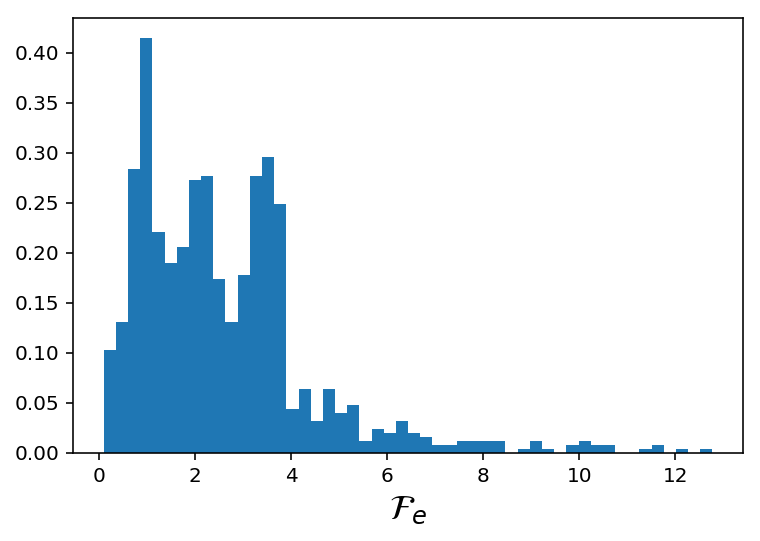

In [60]:
nbins = 50
#plt.hist(fstat_array,bins = nbins,density = True)
plt.hist(festat_array_test,bins = nbins,density = True)
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{e}$',fontsize = 'xx-large')
plt.show()